In [1]:
import sys, os
import ROOT
import numpy as np
import xgboost as xgb
import pandas as pd
from CMS_lumi import CMS_lumi
from colorPrint import *
from ROOT import RooFit

ROOT.RooMsgService.instance().setSilentMode(True)
ROOT.gROOT.ProcessLine(""" #include "../interface/RooCruijff.h"  """)
ROOT.gSystem.Load("../interface/libCruijff.so")
ROOT.gROOT.LoadMacro("../interface/tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
from ROOT import RooCruijff

Welcome to JupyROOT 6.24/02


/home/chenghan/.conda/envs/hdalitz2/lib/python3.8/site-packages/ROOT/_facade.py:150: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  return _orig_ihook(name, *args, **kwds)
/home/chenghan/.conda/envs/hdalitz2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
iBE = 1 # 0 for EB and 1 for EE

features = [
    "rho",
    "nVtx",
    "eleSCEta_Lead",
    "eleSCPhi_Lead",
    "eleSCRawEn_Lead",
    "eleCalibPt_Lead",

    "eledEtaAtVtx_Lead",
    "eledPhiAtVtx_Lead",
    "elePtError_Lead",
    "eleHoverE_Lead",
    "eleEoverP_Lead",
    "eleEoverPout_Lead",
    "eleEoverPInv_Lead",

    "eleSCEtaWidth_Lead",
    "eleSCPhiWidth_Lead",
    "eleSigmaIEtaIEtaFull5x5_Lead",
    "eleSigmaIPhiIPhiFull5x5_Lead",
    "eleR9Full5x5_Lead",
    "eleBrem_Lead",

    "gsfPtSum_Lead",
    "gsfPtRatio_Lead",
    "diTrkPt",
    "gsfDeltaR_Lead"
]
if iBE == 1:
    features.append("eleESEnToRawE_Lead")


cut_base = "elePresel_Lead == 1 && eleCalibPt_Lead > 25 && category == 2"
cut_region = "fabs(eleSCEta_Lead) < 1.479"
if iBE == 1:
    cut_region = "fabs(eleSCEta_Lead) >= 1.479 && fabs(eleSCEta_Lead) < 2.5"
# cut_target = "target < 2 && target > 0"

ROOT.EnableImplicitMT(20)
data = ROOT.RDataFrame("miniTree", "../reg_signal.root")\
           .Define("target",    
                #    "diGenEle.Pt()/eleCalibPt_Lead"
                   "diGenEle.Pt()/elePt_Lead"
            )\
           .Define("diTrkPt",   "diTrk.Pt()")\
           .Define("RatioRL",   "(eleEright_Lead - eleEleft_Lead)/(eleEright_Lead + eleEleft_Lead)")\
           .Define("RatioBT",   "(eleEtop_Lead - eleEbottom_Lead)/(eleEtop_Lead + eleEbottom_Lead)")\
           .Define("eleCalibPtToRawE", "eleCalibPt_Lead/eleSCRawEn_Lead")\
           .Define("diTrkPtToRawE", "diTrkPt/eleSCRawEn_Lead")\
           .Define("eleEmaxToRawE", "eleEmax_Lead/eleSCRawEn_Lead")\
           .Define("eleE2ndToRawE", "eleE2nd_Lead/eleSCRawEn_Lead")\
           .Define("eleE2x2ToRawE", "eleE2x2Full5x5_Lead/eleSCRawEn_Lead")\
           .Define("eleE2x5ToRawE", "eleE2x5Full5x5_Lead/eleSCRawEn_Lead")\
           .Define("eleE1x3ToRawE", "eleE1x3Full5x5_Lead/eleSCRawEn_Lead")\
           .Define("genPt",     "diGenEle.Pt()")\
           .Filter("{} && {}".format(cut_base, cut_region))\
           .AsNumpy(columns=features+["instwei", "target", "mcwei", "genwei", "puwei", "genPt", "elePt_Lead"])

df = pd.DataFrame(data)
df

,rho,nVtx,eleSCEta_Lead,eleSCPhi_Lead,eleSCRawEn_Lead,eleCalibPt_Lead,eledEtaAtVtx_Lead,eledPhiAtVtx_Lead,elePtError_Lead,eleHoverE_Lead,...,diTrkPt,gsfDeltaR_Lead,eleESEnToRawE_Lead,instwei,target,mcwei,genwei,puwei,genPt,elePt_Lead
0,24.615305,34,1.881104,-3.078345,518.029175,165.653458,-0.000872,0.004603,2.503479,0.007430,...,166.884995,0.000674,0.050031,0.018195,0.989684,0.000011,-1.0,1.003234,163.061768,164.761490
1,22.497538,40,-1.961429,2.447338,494.825684,140.532227,-0.000925,-0.005231,1.679073,0.008595,...,135.716782,0.000731,0.047937,0.018195,0.997193,0.000011,1.0,1.059182,145.618057,146.027969
2,28.196531,35,1.771492,-2.482995,143.891205,53.910492,0.001745,0.007324,1.261122,0.001519,...,86.997238,0.055511,0.053162,0.018195,1.472427,0.000011,1.0,0.986530,78.124077,53.058029
3,24.728802,30,2.150896,0.556029,242.743637,60.540218,-0.000388,0.008934,1.527308,0.004435,...,61.239651,0.011651,0.037016,0.018195,1.017802,0.000011,1.0,1.007231,61.742973,60.663021
4,10.543830,20,-1.978783,-0.697987,201.277618,60.321770,-0.000667,-0.000602,1.026264,0.019020,...,75.386948,0.085910,0.058436,0.018195,1.104130,0.000011,1.0,1.020131,67.165184,60.830879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928336,26.111132,42,1.994206,0.899352,285.938721,80.819572,-0.002563,-0.014077,1.254145,0.009384,...,104.825066,0.001834,0.030149,0.028263,1.001679,0.000011,1.0,1.175886,80.864090,80.728539
2928337,18.824400,36,-2.352489,0.554222,300.134857,59.466026,0.001409,-0.011570,1.233802,0.010098,...,87.562347,0.001982,0.030396,0.028263,0.994936,0.000011,1.0,1.080072,58.361904,58.658951
2928338,17.833481,27,1.865066,-1.843694,152.339584,55.555397,0.000526,0.011404,1.146499,0.012510,...,73.664932,0.002422,0.124386,0.028263,1.035921,0.000011,1.0,1.052754,56.463131,54.505257
2928339,27.028183,36,2.246492,0.332232,260.092560,59.998856,0.002313,0.005658,1.149143,0.002860,...,68.849899,0.009129,0.074281,0.028263,0.978564,0.000011,1.0,0.989832,58.257648,59.533844


In [3]:
import pickle as pkl

region = "EB" if iBE == 0 else "EE"
# models_path = "../reg_results/XGBRegression_WithRobustScaling_NoOpt_EGMRegTarget_NewF_{}/XGB_Regression.txt".format(region)
models_path = "/data4/chenghan/external/RegressionV4/XGBRegression_WithRobustScaling_Opt_EGMRegTarget_{}/XGB_Regression.txt".format(region)

reg = xgb.Booster()
reg.load_model(models_path)

scaler = pkl.load(open("/data4/chenghan/external/RegressionV4/XGBRegression_WithRobustScaling_Opt_EGMRegTarget_{}/RobustScaler.pkl".format(region), "rb"))
x_values = scaler.transform(df.loc[:, features].values)
# x_values = df.loc[:, features].values
preds = reg.predict(xgb.DMatrix(x_values))
preds

array([0.99175984, 0.989507  , 1.0748883 , ..., 1.0186623 , 1.0120838 ,
       0.9855327 ], dtype=float32)

In [4]:
df["eleHDALRegPt_Lead"] = preds * df["elePt_Lead"]
# df["eleHDALRegPt_Lead"] = preds * df["eleCalibPt_Lead"]
# df[["genPt", "eleCalibPt_Lead", "eleHDALRegPt_Lead"]]
df[["genPt", "elePt_Lead", "eleHDALRegPt_Lead"]]

,genPt,elePt_Lead,eleHDALRegPt_Lead
0,163.061768,164.761490,163.403824
1,145.618057,146.027969,144.495697
2,78.124077,53.058029,57.031456
3,61.742973,60.663021,60.501575
4,67.165184,60.830879,65.740265
...,...,...,...
2928336,80.864090,80.728539,80.689247
2928337,58.361904,58.658951,58.495777
2928338,56.463131,54.505257,55.522453
2928339,58.257648,59.533844,60.253239


In [13]:
df["resp_XGB"] = df["eleHDALRegPt_Lead"]/df["genPt"]
df["resp_EGM"] = df["elePt_Lead"]/df["genPt"]
df["wei"] = df["mcwei"] * df["genwei"]
genPt = df["genPt"].to_numpy()
resp_XGB = df["resp_XGB"].to_numpy()
resp_EGM = df["resp_EGM"].to_numpy()
weight = df["wei"].to_numpy()
# weight = np.ones(len(df["wei"]))
bins = 400 if iBE == 0 else 300
# bins = 100 if iBE == 0 else 100
# hist2D_XGB = ROOT.TH2D("hist2D_XGB", "", 15, 25, 220, bins, 0, 2)
# hist2D_EGM = ROOT.TH2D("hist2D_EGM", "", 15, 25, 220, bins, 0, 2)
hist2D_XGB = ROOT.TH2D("hist2D_XGB", "", 13, 25, 155, bins, 0, 2)
hist2D_EGM = ROOT.TH2D("hist2D_EGM", "", 13, 25, 155, bins, 0, 2)

for i in range(len(resp_XGB)):
    hist2D_XGB.Fill(genPt[i], resp_XGB[i], weight[i])
    hist2D_EGM.Fill(genPt[i], resp_EGM[i], weight[i])
    
hist2D_XGB

Warning in <TROOT::Append>: Replacing existing TH1: hist2D_XGB (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist2D_EGM (Potential memory leak).


In [15]:
def fit_resp(hist, pt_do, pt_up, method):
    # define fiiting pdf
    # Cruijff is stable for asymmetrical distributions with long tails
    x      = ROOT.RooRealVar("x", " ", 0, 2)
    # mu     = ROOT.RooRealVar("mu", " ", 1., 0.95, 1.05)
    # sigmaL = ROOT.RooRealVar("sigmaL", " ", 0.002, 0.0, 0.5)
    # sigmaR = ROOT.RooRealVar("sigmaR", " ", 0.002, 0.0, 0.5)
    # alphaL = ROOT.RooRealVar("alphaL", " ", 0.1, 0, 2)
    # alphaR = ROOT.RooRealVar("alphaR", " ", 0.1, 0, 2)
    
    # mu      = ROOT.RooRealVar("mu",   " ",  1., 0.95, 1.05)
    # sigma   = ROOT.RooRealVar("sigma",  " ", hist.GetStdDev(), 0.0, 0.5)
    # alpha1  = ROOT.RooRealVar("alpha1", " ", 1,   1e-1,   3)
    # alpha2  = ROOT.RooRealVar("alpha2", " ", 1,   1e-1,   3)
    # n1      = ROOT.RooRealVar("n1",     " ", 80,    1,     200)
    # n2      = ROOT.RooRealVar("n2",     " ", 80,    1,     200)
    # pdf     = ROOT.RooCrystalBall("dcb", "dcb", x, mu, sigma, alpha1, n1, alpha2, n2)
    
    mu      = ROOT.RooRealVar("mu",   " ",  hist.GetBinCenter(hist.GetMaximumBin()), 0.95, 1.05)
    sigma   = ROOT.RooRealVar("sigma",  " ", hist.GetStdDev(), 0.0, 0.5)
    alpha1  = ROOT.RooRealVar("alpha1", " ", 1,   1e-1,   3)
    alpha2  = ROOT.RooRealVar("alpha2", " ", 1,   1e-1,   3)
    n1      = ROOT.RooRealVar("n1",     " ", 80,    1,     200)
    n2      = ROOT.RooRealVar("n2",     " ", 80,    1,     200)
    pdf     = ROOT.RooCrystalBall("dcb", "dcb", x, mu, sigma, alpha1, n1, alpha2, n2)
    
    # pdf = ROOT.RooCruijff("cruijff", " ", x, mu, sigmaL, sigmaR, alphaL, alphaR)
    dh = ROOT.RooDataHist("dh", "dh", x, ROOT.RooFit.Import(hist))
    
    # perform the fitting
    # x.setRange("NormRange", 0, 2)
    x.setRange("fitRange", 0.65, 1.35)
    for i in range(10):
        results = pdf.fitTo(
            dh, 
            ROOT.RooFit.Minimizer("Minuit2", "minimize"),
            ROOT.RooFit.Range("fitRange"),
            ROOT.RooFit.Save(1), ROOT.RooFit.Strategy(2),
            ROOT.RooFit.SumW2Error(1), 
            ROOT.RooFit.PrintLevel(1)
        )
        if results.status() == 0:
            break
    results.Print("V")

    # visualization
    canv = ROOT.TCanvas("canv", "", 800, 650)
    canv.cd()
    canv.SetRightMargin(0.04)
    canv.SetTopMargin(0.075)
    canv.SetLeftMargin(0.14)
    canv.SetBottomMargin(0.14)

    # nbins = 60 if iBE == 0 else 400
    xframe = x.frame(0.65, 1.35)
    dh.plotOn(
        xframe,
        RooFit.Name("hist"),
        # RooFit.Binning(nbins),
        RooFit.MarkerStyle(ROOT.kFullCircle), RooFit.MarkerSize(1.2),
        RooFit.LineWidth(2)
    )
    pdf.plotOn(
        xframe,
        RooFit.Name("pdf"),
        # RooFit.NormRange("NormRange"),
        RooFit.LineColor(ROOT.kRed - 4), RooFit.LineWidth(2)
    )
    dh.plotOn(
        xframe,
        RooFit.Name("hist"),
        # RooFit.Binning(nbins),
        RooFit.MarkerStyle(ROOT.kFullCircle), RooFit.MarkerSize(1.2),
        RooFit.LineWidth(2)
    )
    xframe.SetTitle("")
    xframe.GetXaxis().SetTitleSize(0.047)
    xframe.GetXaxis().SetLabelSize(0.046)
    xframe.GetXaxis().SetTitleOffset(1.24)
    xframe.GetXaxis().SetLabelOffset(0.012)
    xframe.GetXaxis().SetTitle("p^{reco}_{T} / p^{true}_{T}")
    # xframe.GetYaxis().SetTitle("Events / 0.005")
    xframe.GetYaxis().SetTitleSize(0.047)
    xframe.GetYaxis().SetLabelSize(0.046)
    xframe.GetYaxis().SetTitleOffset(1.4)
    xframe.SetMaximum(xframe.GetMaximum() * 1.5)
    xframe.SetMinimum(0)
    xframe.Draw()
    
    leg = ROOT.TLegend(0.17, 0.64, 0.45, 0.76)
    leg.SetTextFont(42)
    leg.SetTextSize(0.04)
    leg.SetFillColor(0)
    leg.SetLineColor(0)
    leg.AddEntry(xframe.findObject("hist"), "Simulation", "LE1P")
    leg.AddEntry(xframe.findObject("pdf"), "DCB", "l")
    leg.Draw("same")

    # var1 = results.floatParsFinal().find("mu")
    # var2 = results.floatParsFinal().find("sigmaL")
    # var3 = results.floatParsFinal().find("sigmaR")
    var1 = results.floatParsFinal().find("mu")
    var2 = results.floatParsFinal().find("sigma")
    ltx = ROOT.TLatex()
    ltx.SetNDC()
    ltx.SetTextFont(42)
    ltx.SetTextSize(0.045)
    ltx.DrawLatex(0.58, 0.86, " #mu = %.4f #pm %.4f" %(var1.getValV(), var1.getError()))
    ltx.DrawLatex(0.58, 0.81, " #sigma = %.4f #pm %.4f" %(var2.getValV(), var2.getError()))
    # ltx.DrawLatex(0.58, 0.81, " #sigma_{L} = %.4f #pm %.4f" %(var2.getValV(), var2.getError()))
    # ltx.DrawLatex(0.58, 0.76, " #sigma_{R} = %.4f #pm %.4f" %(var3.getValV(), var3.getError()))
    # ltx.DrawLatex(0.58, 0.68, " #sigma_{ave} #equiv #frac{#sigma_{L} + #sigma_{R}}{2} = %.4f" %((var2.getValV()+var3.getValV())/2))
    
    region = "ECAL Barrrel" if iBE == 0 else "ECAL Endcap"
    ltx.DrawLatex(0.18, 0.58, "%d < p^{true}_{T} < %d GeV" %(pt_do, pt_up))
    ltx.DrawLatex(0.18, 0.5, region)
    
    CMS_lumi(canv, 5, 10, "", 2017, True, "Simulation Preliminary", "H #rightarrow #gamma* #gamma #rightarrow ee#gamma", "")
    canv.Update()
    canv.RedrawAxis()

    reg_ext = "EB" if iBE == 0 else "EE"
    directory = "../plots/validation/resp_fit_old/{}".format(reg_ext)
    if not os.path.exists(directory):
        os.makedirs(directory)
    canv.Print("{}/respFit_pt_{}_{}To{}GeV.pdf".format(directory, method, int(pt_do), int(pt_up)))
    canv.Close()
    
    return results

In [16]:

x_mu, y_mu, xerr_mu, yerr_mu = [], [], [], []
x_width, y_width, xerr_width, yerr_width = [], [], [], []
for i in range(hist2D_XGB.GetNbinsX()):
# for i in range(1):
    pt_do = hist2D_XGB.GetXaxis().GetBinLowEdge(i+1) 
    pt_up = hist2D_XGB.GetXaxis().GetBinUpEdge(i+1)
    print(color.GREEN + "[INFO] Perform the fitting in range [%d, %d]" %(int(pt_do), int(pt_up)) + color.END)
    histName_XGB = "hist1D_XGB_{}To{}".format(pt_do, pt_up)
    hist_XGB = hist2D_XGB.ProjectionY(histName_XGB, i+1, i+1).Clone()
    fitRes = fit_resp(hist_XGB, pt_do, pt_up, "XGB")
    
    x_mu.append(pt_do+(pt_up-pt_do)/2)
    y_mu.append(fitRes.floatParsFinal().find("mu").getValV())
    xerr_mu.append((pt_up-pt_do)/2)
    yerr_mu.append(fitRes.floatParsFinal().find("mu").getError())
    
    # sigma_ave = 0.5 * (fitRes.floatParsFinal().find("sigmaL").getValV() + fitRes.floatParsFinal().find("sigmaR").getValV())
    # sigma_ave_err = np.sqrt(pow(fitRes.floatParsFinal().find("sigmaL").getError(), 2) + pow(fitRes.floatParsFinal().find("sigmaR").getError(), 2))
    
    sigma_ave = fitRes.floatParsFinal().find("sigma").getValV()
    sigma_ave_err = fitRes.floatParsFinal().find("sigma").getError()
    x_width.append(pt_do+(pt_up-pt_do)/2)
    y_width.append(sigma_ave)
    xerr_width.append((pt_up-pt_do)/2)
    yerr_width.append(sigma_ave_err)
    
mu_err_XGB = ROOT.TGraphErrors(hist2D_XGB.GetNbinsX(), np.array(x_mu), np.array(y_mu), np.array(xerr_mu), np.array(yerr_mu)) 
width_err_XGB = ROOT.TGraphErrors(hist2D_XGB.GetNbinsX(), np.array(x_width), np.array(y_width), np.array(xerr_width), np.array(yerr_width)) 
width_err_XGB.Print()

[INFO] Perform the fitting in range [25, 35]
[INFO] Perform the fitting in range [35, 45]
[INFO] Perform the fitting in range [45, 55]
[INFO] Perform the fitting in range [55, 65]
[INFO] Perform the fitting in range [65, 75]
[INFO] Perform the fitting in range [75, 85]
[INFO] Perform the fitting in range [85, 95]
[INFO] Perform the fitting in range [95, 105]
[INFO] Perform the fitting in range [105, 115]
[INFO] Perform the fitting in range [115, 125]
[INFO] Perform the fitting in range [125, 135]
[INFO] Perform the fitting in range [135, 145]
[INFO] Perform the fitting in range [145, 155]
[#0] WARNING:InputArguments -- The parameter 'sigma' with range [0, 0.5] of the RooCrystalBall 'dcb' exceeds the safe range of (0, inf). Advise to limit its range.
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fitRange' created with bounds [0.65,1.35]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_dcb_dh) constructing test statistic for sub-range named fitRange
[#1] INFO:Eval -- Ro

Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_XGB_25To35GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_XGB_35To45GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_XGB_45To55GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_XGB_55To65GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_XGB_65To75GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_XGB_75To85GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_XGB_85To95GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_XGB_95To105GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit

In [17]:
x_mu_egm, y_mu_egm, xerr_mu_egm, yerr_mu_egm = [], [], [], []
x_width_egm, y_width_egm, xerr_width_egm, yerr_width_egm = [], [], [], []
for i in range(hist2D_EGM.GetNbinsX()):
    pt_do = hist2D_EGM.GetXaxis().GetBinLowEdge(i+1) 
    pt_up = hist2D_EGM.GetXaxis().GetBinUpEdge(i+1)
    print(color.GREEN + "[INFO] Perform the fitting in range [%d, %d]" %(int(pt_do), int(pt_up)) + color.END)
    histName_EGM = "hist1D_EGM_{}To{}".format(pt_do, pt_up) 
    hist_EGM = hist2D_EGM.ProjectionY(histName_EGM, i+1, i+1).Clone()
    fitRes = fit_resp(hist_EGM, pt_do, pt_up, "EGM")
    
    x_mu_egm.append(pt_do+(pt_up-pt_do)/2)
    y_mu_egm.append(fitRes.floatParsFinal().find("mu").getValV())
    xerr_mu_egm.append((pt_up-pt_do)/2)
    yerr_mu_egm.append(fitRes.floatParsFinal().find("mu").getError())
    
    # sigma_ave = 0.5 * (fitRes.floatParsFinal().find("sigmaL").getValV() + fitRes.floatParsFinal().find("sigmaR").getValV())
    # sigma_ave_err = np.sqrt(pow(fitRes.floatParsFinal().find("sigmaL").getError(), 2) + pow(fitRes.floatParsFinal().find("sigmaR").getError(), 2))
    
    sigma_ave = fitRes.floatParsFinal().find("sigma").getValV()
    sigma_ave_err = fitRes.floatParsFinal().find("sigma").getError()
    x_width_egm.append(pt_do+(pt_up-pt_do)/2)
    y_width_egm.append(sigma_ave)
    xerr_width_egm.append((pt_up-pt_do)/2)
    yerr_width_egm.append(sigma_ave_err)
    
mu_err_EGM = ROOT.TGraphErrors(hist2D_EGM.GetNbinsX(), np.array(x_mu_egm), np.array(y_mu_egm), np.array(xerr_mu_egm), np.array(yerr_mu_egm)) 
width_err_EGM = ROOT.TGraphErrors(hist2D_EGM.GetNbinsX(), np.array(x_width_egm), np.array(y_width_egm), np.array(xerr_width_egm), np.array(yerr_width_egm)) 
width_err_EGM.Print()

[INFO] Perform the fitting in range [25, 35]
[INFO] Perform the fitting in range [35, 45]
[INFO] Perform the fitting in range [45, 55]
[INFO] Perform the fitting in range [55, 65]
[INFO] Perform the fitting in range [65, 75]
[INFO] Perform the fitting in range [75, 85]
[INFO] Perform the fitting in range [85, 95]
[INFO] Perform the fitting in range [95, 105]
[INFO] Perform the fitting in range [105, 115]
[INFO] Perform the fitting in range [115, 125]
[INFO] Perform the fitting in range [125, 135]
[INFO] Perform the fitting in range [135, 145]
[INFO] Perform the fitting in range [145, 155]
[#0] WARNING:InputArguments -- The parameter 'sigma' with range [0, 0.5] of the RooCrystalBall 'dcb' exceeds the safe range of (0, inf). Advise to limit its range.
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fitRange' created with bounds [0.65,1.35]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_dcb_dh) constructing test statistic for sub-range named fitRange
[#1] INFO:Eval -- Ro

Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_EGM_25To35GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_EGM_35To45GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_EGM_45To55GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_EGM_55To65GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_EGM_65To75GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_EGM_75To85GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_EGM_85To95GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit_old/EE/respFit_pt_EGM_95To105GeV.pdf has been created
Info in <TCanvas::Print>: pdf file ../plots/validation/resp_fit

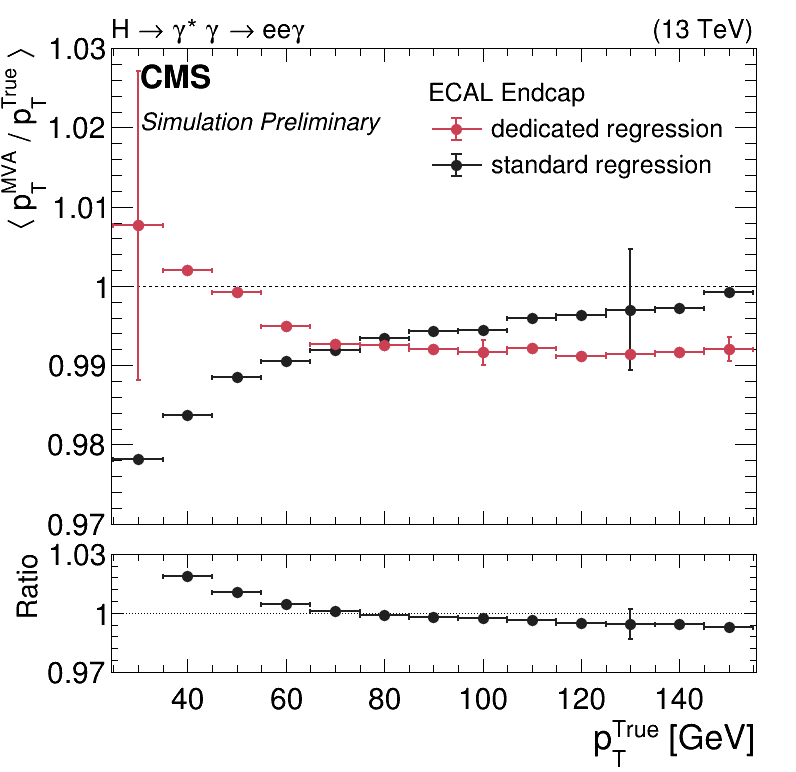

In [18]:
c1 = ROOT.TCanvas("c1", "", 800, 800)
c1.cd()

pad1 = ROOT.TPad("pad1", " ", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.03)
pad1.SetTopMargin(0.09)
pad1.SetRightMargin(0.05)
pad1.SetLeftMargin(0.14)
pad1.Draw()
pad1.cd()

mu_err_XGB.GetXaxis().SetTitle("")
mu_err_XGB.GetYaxis().SetTitle("#LT p^{MVA}_{T} / p^{True}_{T} #GT")
mu_err_XGB.GetYaxis().SetRangeUser(0.97, 1.03)
mu_err_XGB.GetYaxis().SetNdivisions(506)
mu_err_XGB.GetYaxis().SetTickSize(0.03)
mu_err_XGB.GetYaxis().SetTitleSize(0.06)
mu_err_XGB.GetYaxis().SetLabelSize(0.06)
mu_err_XGB.GetYaxis().SetTitleOffset(1.15)

mu_err_XGB.GetXaxis().SetRangeUser(25, 155)
mu_err_XGB.GetXaxis().SetTickSize(0.03)
mu_err_XGB.GetXaxis().SetTitleSize(0.06)
mu_err_XGB.GetXaxis().SetLabelSize(0.05)
mu_err_XGB.GetXaxis().SetLabelOffset(0.1)
mu_err_XGB.GetXaxis().SetTitleOffset(1)
mu_err_XGB.SetMarkerColor(ROOT.TColor.GetColor("#CC4054"))
mu_err_XGB.SetMarkerSize(1.4)
mu_err_XGB.SetMarkerStyle(20)
mu_err_XGB.SetLineColor(ROOT.TColor.GetColor("#CC4054"))
mu_err_XGB.SetLineWidth(2)
mu_err_XGB.Draw("AP")

mu_err_EGM.SetMarkerColor(ROOT.TColor.GetColor("#202020"))
mu_err_EGM.SetMarkerSize(1.4)
mu_err_EGM.SetMarkerStyle(20)
mu_err_EGM.SetLineColor(ROOT.TColor.GetColor("#202020"))
mu_err_EGM.SetLineWidth(2)

l = ROOT.TLine(25, 1, 155, 1)
l.SetLineStyle(2)
l.SetLineColor(1)
l.Draw()

mu_err_EGM.Draw("P same")
mu_err_XGB.Draw("P same")

region = "ECAL Barrrel" if iBE == 0 else "ECAL Endcap"
leg = ROOT.TLegend(0.53, 0.66, 0.88, 0.86)
leg.SetHeader(region)
leg.SetTextFont(42)
leg.SetTextSize(0.05)
leg.SetFillColor(0)
leg.SetLineColor(0)
leg.AddEntry(mu_err_XGB, "dedicated regression", "LE1P")
leg.AddEntry(mu_err_EGM, "standard regression", "LE1P")
leg.Draw("same")

CMS_lumi(pad1, 5, 10, "", 2017, True, "Simulation Preliminary", "H #rightarrow #gamma* #gamma #rightarrow ee#gamma", "")
c1.cd()

pad2 = ROOT.TPad("pad2", "", 0, 0, 1, 0.3)
pad2.SetGridy()
pad2.SetRightMargin(0.05)
pad2.SetLeftMargin(0.14)
pad2.SetTopMargin(0.06)
pad2.SetBottomMargin(0.43)
pad2.Draw()
pad2.cd()

nPoints = mu_err_XGB.GetN()
ratio_err = ROOT.TGraphErrors(nPoints)
for i in range(nPoints):
    xp = mu_err_XGB.GetPointX(i)
    yp = mu_err_XGB.GetPointY(i)/mu_err_EGM.GetPointY(i)
    xp_err = mu_err_XGB.GetErrorX(i)
    yp_err = yp * np.sqrt(pow(mu_err_XGB.GetErrorY(i)/mu_err_XGB.GetPointY(i), 2) + pow(mu_err_EGM.GetErrorY(i)/mu_err_EGM.GetPointY(i), 2))
    
    ratio_err.SetPoint(i, xp, yp)
    ratio_err.SetPointError(i, xp_err, yp_err)

ratio_err.SetName("")
ratio_err.SetTitle("")
ratio_err.GetXaxis().SetTitle("p^{True}_{T} [GeV]")
ratio_err.GetYaxis().SetTitle("Ratio")
ratio_err.GetYaxis().SetRangeUser(0.97 , 1.03)

ratio_err.SetMarkerColor(ROOT.TColor.GetColor("#202020"))
ratio_err.SetMarkerSize(1.4)
ratio_err.SetMarkerStyle(20)
ratio_err.SetLineColor(ROOT.TColor.GetColor("#202020"))
ratio_err.SetLineWidth(2)

ratio_err.GetXaxis().SetRangeUser(25, 155)
ratio_err.GetXaxis().SetTickSize(0.03 * (7/3.))
ratio_err.GetXaxis().SetTitleSize(0.16)
ratio_err.GetXaxis().SetTitleOffset(1.2)
ratio_err.GetXaxis().SetLabelSize(0.06  * (7/3.))
ratio_err.GetXaxis().SetLabelOffset(0.05)
ratio_err.GetYaxis().SetTitleSize(0.13)
ratio_err.GetYaxis().SetTitleOffset(0.22 * (7/3.))
ratio_err.GetYaxis().SetLabelSize(0.06  * (7/3.))
ratio_err.GetYaxis().SetNdivisions(502)
ratio_err.Draw("AP")

c1.Draw()

In [10]:
reg_ext = "EB" if iBE == 0 else "EE"
directory = "../plots/validation/resp_mu_old"
if not os.path.exists(directory):
    os.makedirs(directory)

c1.Print("{}/respMu_pt_{}.pdf".format(directory, reg_ext))
c1.Close()

Info in <TCanvas::Print>: pdf file ../plots/validation/resp_mu_old/respMu_pt_EE.pdf has been created


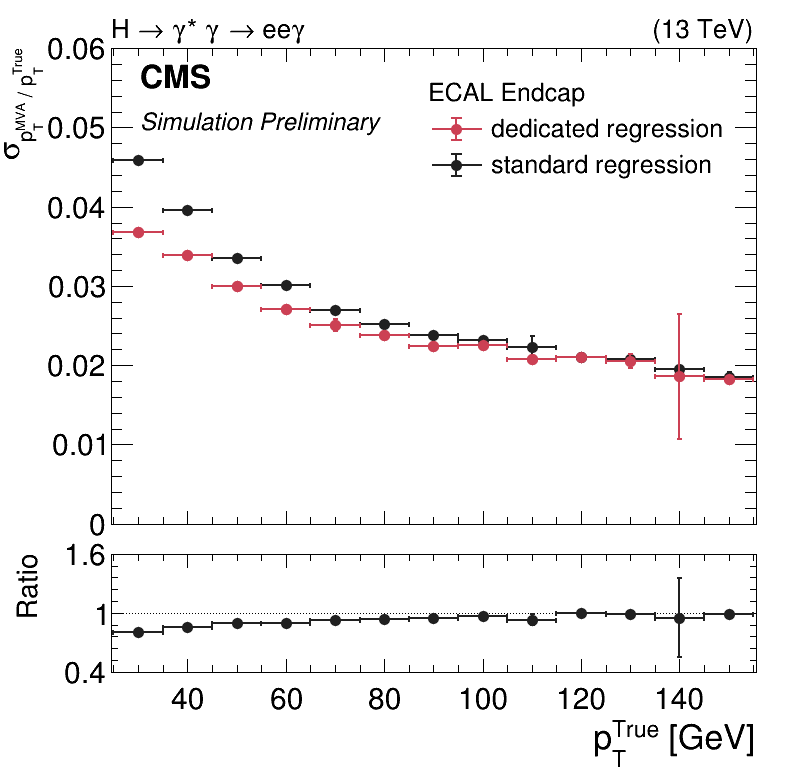

In [11]:
c1 = ROOT.TCanvas("c1", "", 800, 800)
c1.cd()

pad1 = ROOT.TPad("pad1", " ", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.03)
pad1.SetTopMargin(0.09)
pad1.SetRightMargin(0.05)
pad1.SetLeftMargin(0.14)
pad1.Draw()
pad1.cd()

width_err_XGB.GetXaxis().SetTitle("")
width_err_XGB.GetYaxis().SetTitle("#sigma_{p^{MVA}_{T} / p^{True}_{T}}")
width_err_XGB.GetYaxis().SetRangeUser(0, 0.06)
width_err_XGB.GetYaxis().SetNdivisions(506)
width_err_XGB.GetYaxis().SetTickSize(0.03)
width_err_XGB.GetYaxis().SetTitleSize(0.06)
width_err_XGB.GetYaxis().SetLabelSize(0.06)
width_err_XGB.GetYaxis().SetTitleOffset(1.15)

width_err_XGB.GetXaxis().SetRangeUser(25, 155)
width_err_XGB.GetXaxis().SetTickSize(0.03)
width_err_XGB.GetXaxis().SetTitleSize(0.06)
width_err_XGB.GetXaxis().SetLabelSize(0.05)
width_err_XGB.GetXaxis().SetLabelOffset(0.1)
width_err_XGB.GetXaxis().SetTitleOffset(1)
width_err_XGB.SetMarkerColor(ROOT.TColor.GetColor("#CC4054"))
width_err_XGB.SetMarkerSize(1.4)
width_err_XGB.SetMarkerStyle(20)
width_err_XGB.SetLineColor(ROOT.TColor.GetColor("#CC4054"))
width_err_XGB.SetLineWidth(2)
width_err_XGB.Draw("AP")

width_err_EGM.SetMarkerColor(ROOT.TColor.GetColor("#202020"))
width_err_EGM.SetMarkerSize(1.4)
width_err_EGM.SetMarkerStyle(20)
width_err_EGM.SetLineColor(ROOT.TColor.GetColor("#202020"))
width_err_EGM.SetLineWidth(2)

# l = ROOT.TLine(25, 1, 155, 1)
# l.SetLineStyle(2)
# l.SetLineColor(1)
# l.Draw()
    
width_err_EGM.Draw("P same")
width_err_XGB.Draw("P same")

region = "ECAL Barrrel" if iBE == 0 else "ECAL Endcap"
leg = ROOT.TLegend(0.53, 0.66, 0.88, 0.86)
leg.SetHeader(region)
leg.SetTextFont(42)
leg.SetTextSize(0.05)
leg.SetFillColor(0)
leg.SetLineColor(0)
leg.AddEntry(mu_err_XGB, "dedicated regression", "LE1P")
leg.AddEntry(mu_err_EGM, "standard regression", "LE1P")
leg.Draw("same")

CMS_lumi(pad1, 5, 10, "", 2017, True, "Simulation Preliminary", "H #rightarrow #gamma* #gamma #rightarrow ee#gamma", "")
c1.cd()

pad2 = ROOT.TPad("pad2", "", 0, 0, 1, 0.3)
pad2.SetGridy()
pad2.SetRightMargin(0.05)
pad2.SetLeftMargin(0.14)
pad2.SetTopMargin(0.06)
pad2.SetBottomMargin(0.43)
pad2.Draw()
pad2.cd()

nPoints = width_err_XGB.GetN()
ratio_err = ROOT.TGraphErrors(nPoints)
for i in range(nPoints):
    xp = width_err_XGB.GetPointX(i)
    yp = width_err_XGB.GetPointY(i)/width_err_EGM.GetPointY(i)
    xp_err = width_err_XGB.GetErrorX(i)
    yp_err = yp * np.sqrt(pow(width_err_XGB.GetErrorY(i)/width_err_XGB.GetPointY(i), 2) + pow(width_err_EGM.GetErrorY(i)/width_err_EGM.GetPointY(i), 2))
    
    ratio_err.SetPoint(i, xp, yp)
    ratio_err.SetPointError(i, xp_err, yp_err)

ratio_err.SetName("")
ratio_err.SetTitle("")
ratio_err.GetXaxis().SetTitle("p^{True}_{T} [GeV]")
ratio_err.GetYaxis().SetTitle("Ratio")
ratio_err.GetYaxis().SetRangeUser(0.4 , 1.6)

ratio_err.SetMarkerColor(ROOT.TColor.GetColor("#202020"))
ratio_err.SetMarkerSize(1.4)
ratio_err.SetMarkerStyle(20)
ratio_err.SetLineColor(ROOT.TColor.GetColor("#202020"))
ratio_err.SetLineWidth(2)

ratio_err.GetXaxis().SetRangeUser(25, 155)
ratio_err.GetXaxis().SetTickSize(0.03 * (7/3.))
ratio_err.GetXaxis().SetTitleSize(0.16)
ratio_err.GetXaxis().SetTitleOffset(1.2)
ratio_err.GetXaxis().SetLabelSize(0.06  * (7/3.))
ratio_err.GetXaxis().SetLabelOffset(0.05)
ratio_err.GetYaxis().SetTitleSize(0.13)
ratio_err.GetYaxis().SetTitleOffset(0.22 * (7/3.))
ratio_err.GetYaxis().SetLabelSize(0.06  * (7/3.))
ratio_err.GetYaxis().SetNdivisions(502)
ratio_err.Draw("AP")

c1.Draw()

In [12]:
reg_ext = "EB" if iBE == 0 else "EE"
directory = "../plots/validation/resp_width_old"
if not os.path.exists(directory):
    os.makedirs(directory)
c1.Print("{}/respWidth_pt_{}.pdf".format(directory, reg_ext))
c1.Close()

Info in <TCanvas::Print>: pdf file ../plots/validation/resp_width_old/respWidth_pt_EE.pdf has been created
